# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2023/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 27th, 2023 at 23:55. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. 

## A1 Part 1: Visualizing patterns in the data

In this sub-assignment, we recreate some of the plots from Week 2. We look only at the focus-crimes.

In [1]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

For each set of plots below, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).
* First create the week-day plots, the months, the 24-hour cycle, and the 168 hours of the week as barcharts (Week 2, Part 2).
* Next choose a crime type that you like and create a calendar plot (Week 2, Part 4). Don't forget to comment on patterns you observe.
* Finally, choose a different crime type and create a polar plot of its 24hour cycle (Week 2, Part 4). Again, don't forget to comment as you would in a figure text.

## Our answers to A1 

**Question 1.1:** First create the week-day plots, the months, the 24-hour cycle, and the 168 hours of the week as barcharts (Week 2, Part 2).


Loading and preparing the data

In [123]:
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Georgia"

# Load, specify columns and convert to datatime
report_data = pd.read_csv("../Datasets/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
report_data = report_data[['Category', 'Date', 'Time', 'DayOfWeek', 'PdDistrict', 'IncidntNum']]
report_data["Date"] = pd.to_datetime(report_data.Date, format = "%m/%d/%Y")
report_data["Hour"] = pd.to_datetime(report_data["Time"], format="%H:%M").dt.hour

# Extract relevant time-periods
report_data["Weekday"] = report_data["Date"].dt.day_name()
report_data["Month"] = report_data["Date"].dt.month_name()
report_data["12_hours"] = [datetime.strftime(datetime.strptime(str(t), "%H"), "%I %p") for t in report_data["Hour"] ]
report_data["Weekday_Hour"] = report_data["Weekday"] + " " + report_data["12_hours"] 

# Define ordering for the xtics in the plots 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hour_order = [datetime.strftime(datetime.strptime(str(t), "%H"), "%I %p") for t in range(24)]
weekday_hour_order = [weekday + " " + hour for weekday in weekday_order for hour in hour_order]

# Custom xticks to reduce too many labels in the "Hour of the Week"-plot
custom_xticks_weekday_hour_label = []
custom_xticks_weekday_hour_position = []

for position, weekday_hour in enumerate(weekday_hour_order):
   if ("12" in weekday_hour or weekday_hour == "Sunday 11 PM") :
        custom_xticks_weekday_hour_label.extend([weekday_hour])
        custom_xticks_weekday_hour_position.extend([position])

Create functions to plot the number of reported crimes based on crime type and period.

We create functions, as we have to make 4 similar plot where only the period-category varies. 

In [124]:
### Function to blot n reported crimes in a focus-category into a timeperiod
def subset_and_aggregate_data(data, 
                              crime_type, 
                              period_col, 
                              xtick_order):

    ''' 
    subset by crime_type and count number of report within each category
    in the period column. Return a sorted Pd.Series based on xtick_order.
    '''
    
    sub_data = data.query(f"Category == '{crime_type}'")
    reports_in_periods = sub_data.value_counts(period_col)
    return reports_in_periods.reindex(xtick_order)

def make_bar_plot(data,
                  crime_type, 
                  period_col, 
                  xtick_order, 
                  ax, 
                  exclude_ylabel = False,
                  exclude_xticks = True,
                  costum_xticks_label = False,
                  costum_xticks_position = False):
    
    ''' 
    Plot bar plot with number of reports on y, and period on x. 
    Calls subset_and_aggregate_data() for plot data. 
    '''    

    reports_in_periods = subset_and_aggregate_data(data, crime_type, period_col, xtick_order)
    reports_in_periods.plot.bar(ax=ax, color = "skyblue")
    ax.set_xlabel("")

    if exclude_ylabel:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Crimes reported")

    # Make room for title
    ax.set_ylim([0,reports_in_periods.max() * 1.2])
    # Set title
    ax.set_title(label = crime_type.title(), y=0.88, loc='center')
    # Remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if costum_xticks_label:
        ax.set_xticks(ticks = costum_xticks_position, labels=costum_xticks_label, rotation=90)

    if exclude_xticks:
        ax.set_xticks([])


def update_axes_idx(itr, 
                    ax_row_idx, 
                    ax_col_idx):
    
    ''' 
    Function to automatically navigate the ax-element. 
    After every second iteration, raise the row idx and
    reset the column idx. Return updated indices.
    ''' 

    if (itr % 2) == 1: # after uneven iterations - new row, reset col_idx
        ax_row_idx += 1
        ax_col_idx = 0

    else: # after even iterations - Next column
        ax_col_idx += 1

    return ax_row_idx, ax_col_idx


def plot_reports_in_periods(data, 
                            period_col, 
                            xtick_order, 
                            x_label, 
                            title, 
                            n_fig_rows, 
                            n_fig_cols, 
                            figsize,
                            costum_xticks_label = False,
                            costum_xticks_position = False,
                            exclude_xticks = True,
                            xlabel_on_bottom_plots_only = True):
    
    ''' 
    Function to plot the occurance of all focuscrimes individually,
    over a specified period. Calls make_bar_plot and update_axes_idx. 
    ''' 
    
    _, ax = plt.subplots(n_fig_rows, n_fig_cols, figsize = figsize)

    ax_row_idx, ax_col_idx = 0, 0 # indexes for the "ax"-attribute

    for itr, cat in enumerate(focuscrimes):

        make_bar_plot(data, 
                      crime_type = cat, 
                      period_col = period_col,
                      xtick_order = xtick_order, 
                      ax = ax[ax_row_idx][ax_col_idx],
                      exclude_ylabel = (itr%2 != 0),
                      exclude_xticks = exclude_xticks, 
                      costum_xticks_label = costum_xticks_label,
                      costum_xticks_position = costum_xticks_position)
        
        ax_row_idx, ax_col_idx = update_axes_idx(itr, ax_row_idx, ax_col_idx)
        
        if (ax_row_idx+1) == n_fig_rows:
            exclude_xticks = False
    
    if xlabel_on_bottom_plots_only:
        ax[n_fig_rows-1][0].set_xlabel(x_label)
        ax[n_fig_rows-1][1].set_xlabel(x_label)

    plt.suptitle(title, y = 1.005, size = 20)
    plt.tight_layout()

**Overall comments regarding the analysis of the plots**

When analyzing the plots below, it is important to note that the y-axes are in absolute numbers and therefore represent different scales. Therefore, direct comparison between the prevalence of different crime types may be misleading. However, one can still compare similarities and differences in the relative patterns of criminal prevalence across the specified periods between diffierent types of criminality. 

Additionally, the observations are based solely on visual inspection/eyeballing of the data. For a more robust and scientifically reliable analysis, statistical tests are needed to determining the statistical significance of the patterns.

***Weekday plot:***

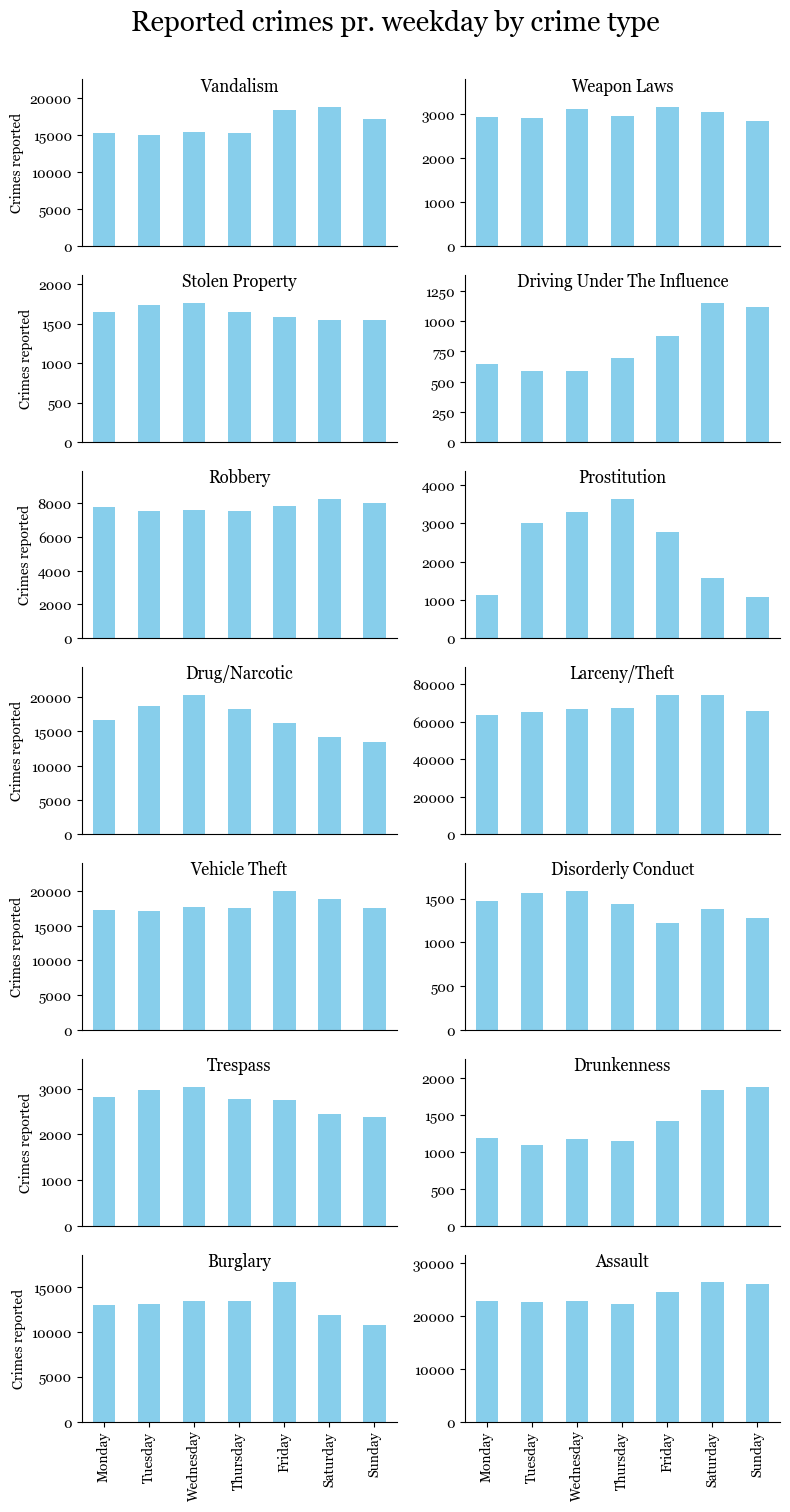

In [125]:
plot_reports_in_periods(report_data, 
                        period_col = "Weekday", 
                        xtick_order = weekday_order, 
                        x_label = None, 
                        title = "Reported crimes pr. weekday by crime type", 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (8, 15))

***Comment on Weekday plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 7 days weekdays, providing insight into their weekly patterns. The majority of the crime types display very little variation throughout the week, e.g. `Weapon laws, Robbery, Assault`, etc. However, some types of criminality exibit clear patterns of prevalence with regard to the day of the week. For instance, `Driving under the influence` and `Drunkenness` are most prevalent on Fridays and Saturdays, coinciding with the weekend, where alcohol consumption is likely to be highest. Conversely, the prevalence of `Prostitution` is highest on Tuesdays, Wednesdays and Thursdays. The explanation for this is less obvious. Maybe this relatively high rate of prostitution around the middle of the working-week could be because people feel more lonely in the weekdays than in the weekends. Another explaination could be, that it is a matter of police resources. As mentioned, we see an increase in crimes relating to  `Driving under the influence` and `Drunkenness`. Maybe the police prioritize their resources the alchohol related incidents, rather than `Prostitution`. Further investigation would be needed to explain this finding. Finally, we also notice the `Drugs/Narcotic` is also most prevalent around the middle of the working-week, i.e. Tuesday, Wednesday, and Thursday. Once again, it is difficult to tell exactly why this pattern emerges, and further studies would be need to get a better understanding of this. 

***Month plot:***

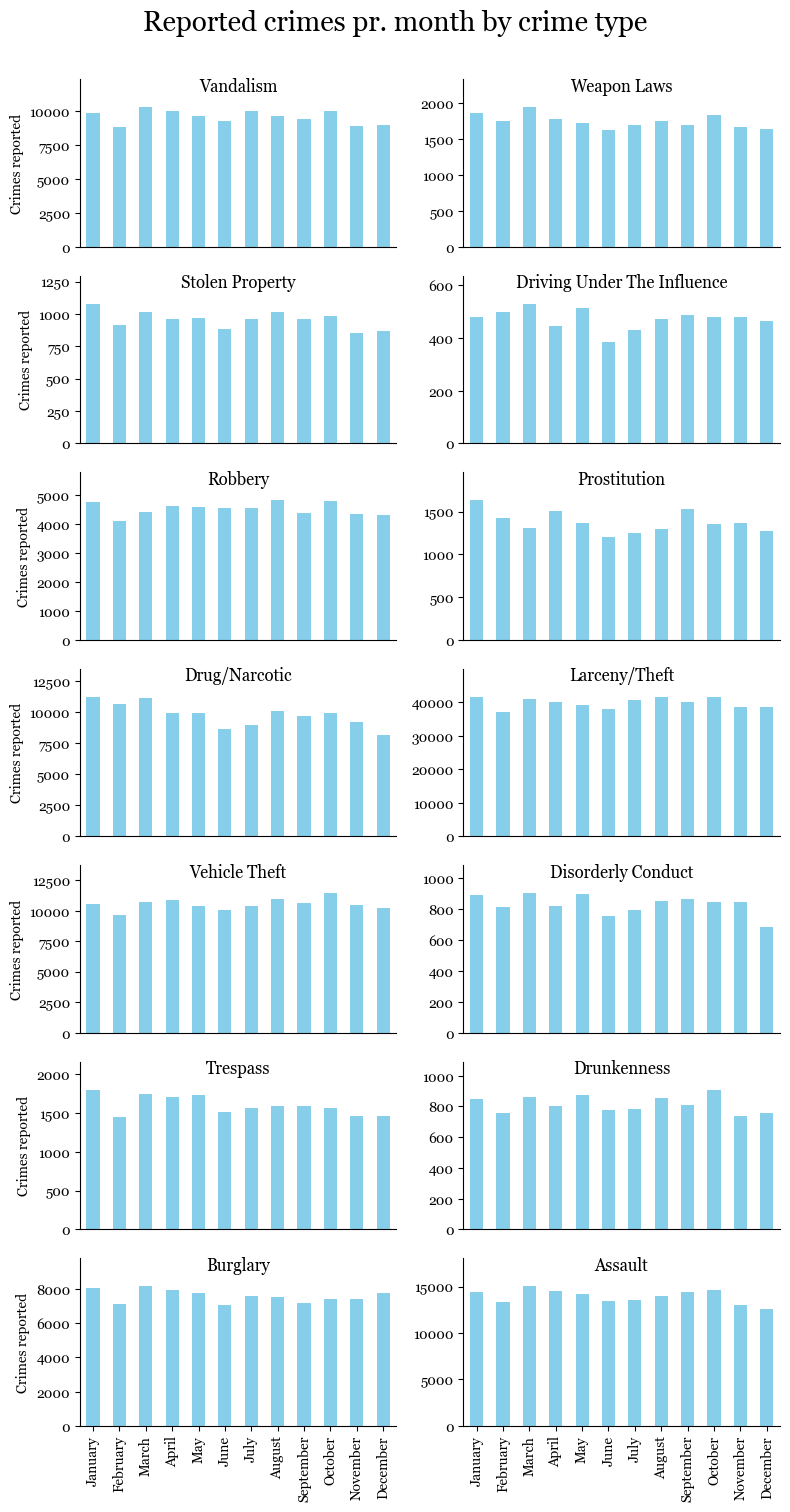

In [96]:
plot_reports_in_periods(report_data, 
                        period_col = "Month", 
                        xtick_order = month_order, 
                        x_label = None, 
                        title = "Reported crimes pr. month by crime type", 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (8, 15))

***Comment on Month plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 12 months of the year, providing insight into their monthly patterns. Across all types of criminality, it appears that December has generaly fewer occurances of crime, compared to the rest of the months. We consider two possible explanations for this pattern. One explanation could simply be, that people are less likely to engage in criminal activities during the Christmas holiday season. Alternatively, the pattern could be explained by a decrease in police presence in December, due to either holiday-related assignments or because there are fewer officers on duty as they celebrate Christmas with their families. Further research on this may provide valuable insights into the factors that influence criminal behavior and law enforcements efforts. 

***Hour plot:***

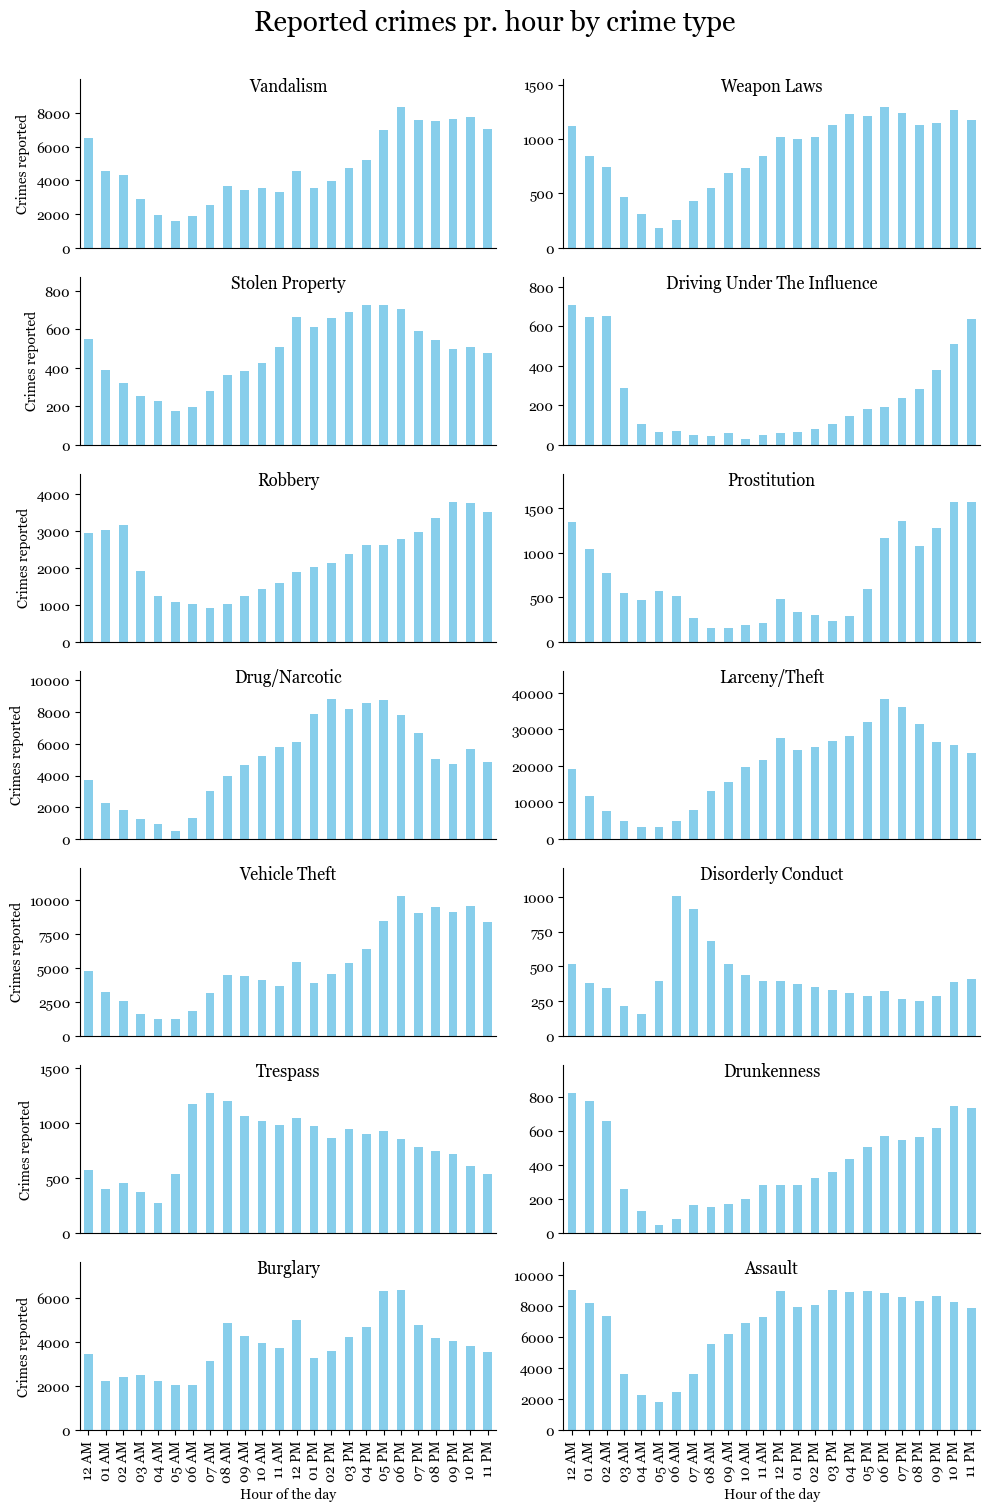

In [97]:
plot_reports_in_periods(report_data, 
                        period_col = "12_hours", 
                        xtick_order = hour_order, 
                        x_label = "Hour of the day", 
                        title = "Reported crimes pr. hour by crime type", 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (10, 15))

***Comment on 24-hour cycle plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 24 hours of the day, providing insight into their daily patterns. Across several of the crime types, the prevalence is lowest during the night and in the very early morning hours. This pattern is evident for offenses such as `Assault, Weapon Laws, Larceny/Theft, and Drug/Narcotic-related`. This is quite reasonable, as most people - i.e. those who commit the crimes or whom the crimes would be commited against - are asleep. `Driving under the influence` also exhibits a different pattern, as it almost exclusively occurs late at night and harly ever occurs during the day time. Where many crime types are most prevalent in the evening or in the early night hours, we notice that `Trespass` occurs mostly in the morning, aroung `6/7AM`. To be honest, we don't know why. Maybe it is caused by people who sleep illegaly on other people's property, which is then discovered in the early morning hours.

Once again, further exploration of these trends could provide valuable insights into the temporal patterns of criminal activity and could help inform law enforcement efforts accordingly.

***Hour of the Week plot:***

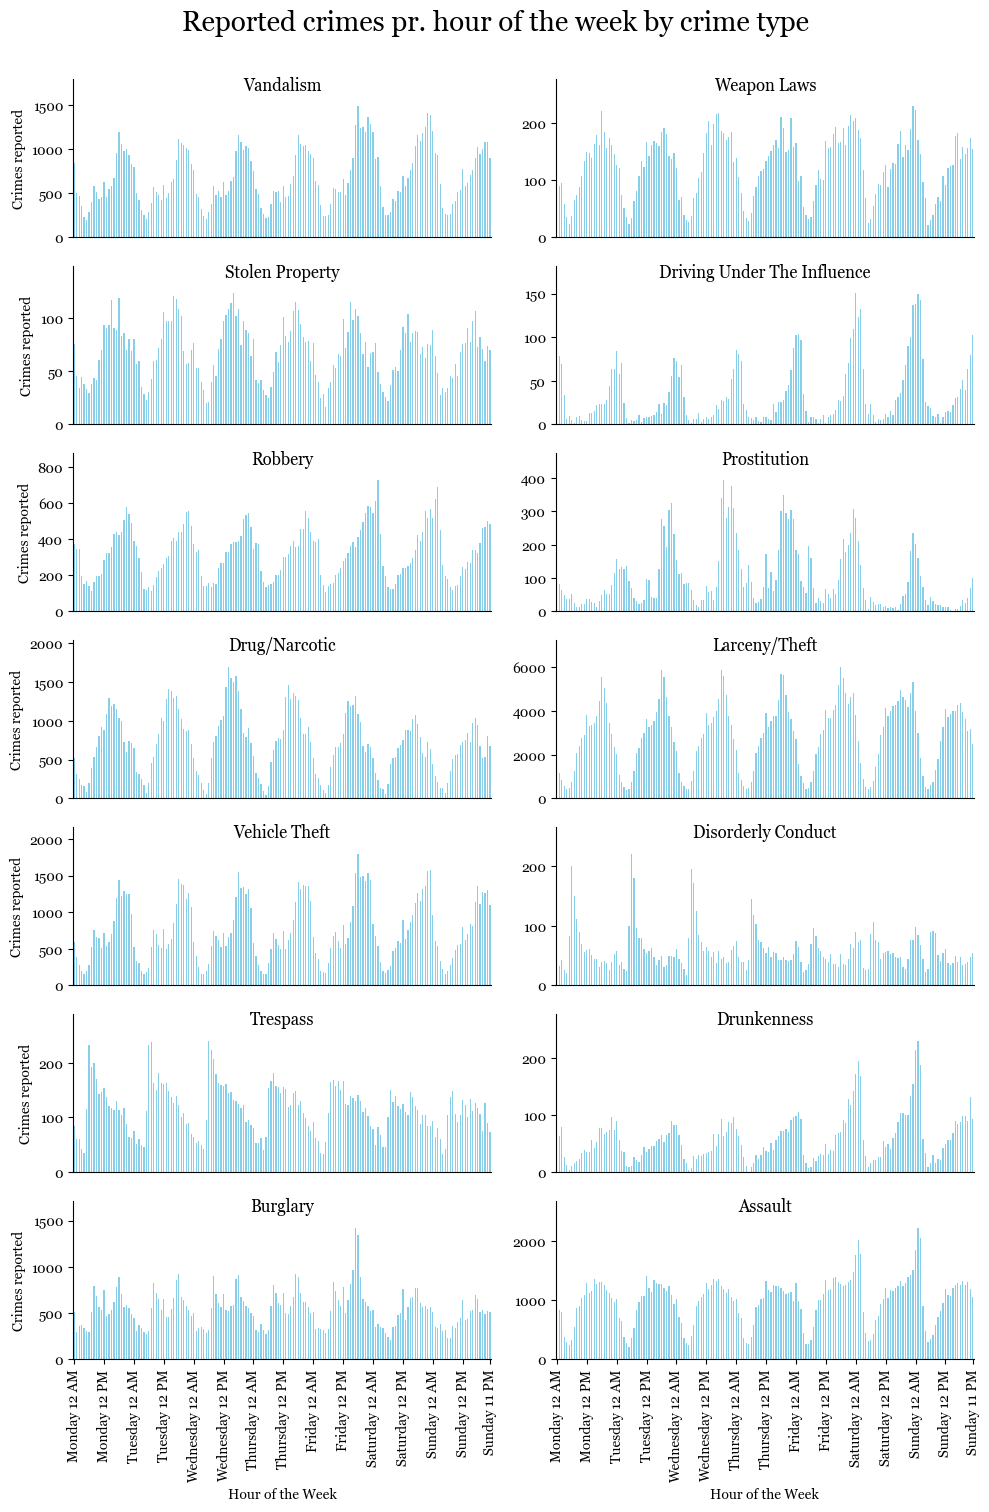

In [126]:
plot_reports_in_periods(report_data, 
                        period_col = "Weekday_Hour", 
                        xtick_order = weekday_hour_order, 
                        x_label = "Hour of the Week", 
                        title = "Reported crimes pr. hour of the week by crime type", 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (10, 15),
                        costum_xticks_label = custom_xticks_weekday_hour_label,
                        costum_xticks_position = custom_xticks_weekday_hour_position)

***Comment on the 168 hours of the week plot:***
The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 168 hours of the week, providing additional insights into both the daily and weekly patterns.

Similar to the previous observations, we see Prostitution following the same pattern of being most prevalent on Tuesdays, Wednesdays, and Thursdays. There is also an overall general pattern of decreased criminal activity during very late night/early morning hours. Additionally, Assault is more prevalent on Saturdays and Sundays, while Burglary is most prevalent on Friday evenings.

However, it is worth noting that these plots are quite complex in wanting to show patterns between 14 crimetypes and time of the week. Thus drawing visual conclusions from them may be challenging. When creating plots, it is important to consider whether their complexity succeeds in simplifying the data to enable the human eye to detect patterns in complex data. In this case, the earlier plots may have been more effective in achieving this goal than these plots. 

**Question 1.2:** Next choose a crime type that you like and create a calendar plot (Week 2, Part 4). Don't forget to comment on patterns you observe.

(<Figure size 1250x510 with 4 Axes>,
 array([<AxesSubplot:ylabel='2003'>, <AxesSubplot:ylabel='2004'>,
        <AxesSubplot:ylabel='2005'>], dtype=object))

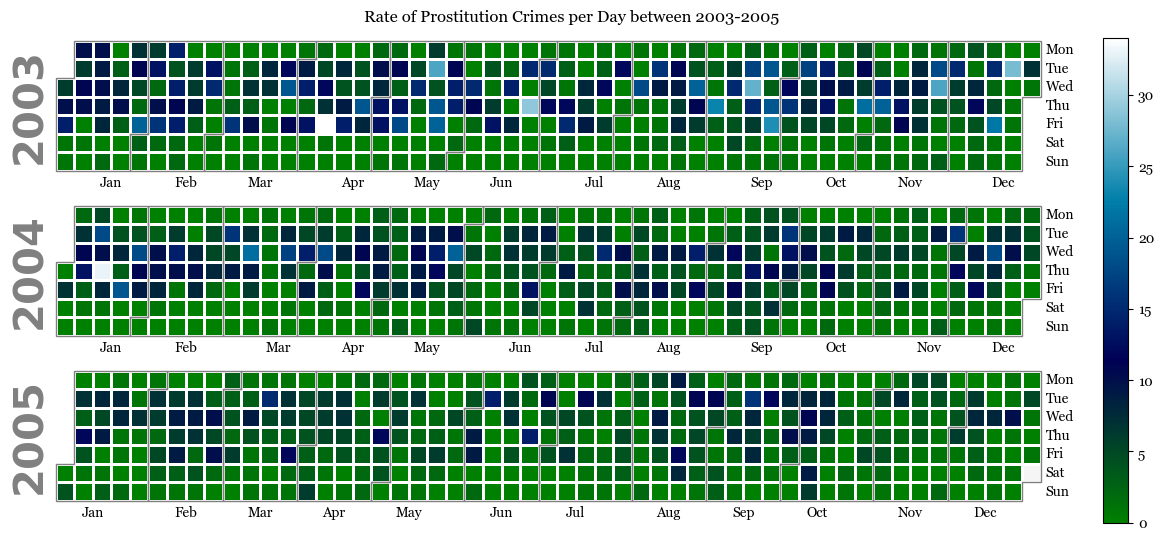

In [17]:
import calplot

# Skal den 
# DEN DER ERROR ER VÆK NU. GIV DET LIGE ET KIG.


plt.rcParams["font.family"] = "Georgia"  

crime_type = "PROSTITUTION"

calplot_data = report_data.assign(Year = report_data.Date.dt.year).query("Year <= 2005").\
    query(f"Category == '{crime_type}'").groupby("Date").count().Category

calplot.calplot(calplot_data, cmap="ocean", suptitle='Rate of Prostitution Crimes per Day between 2003-2005', colorbar=True)
plt.show()

**Answer 1.2:**

In the above plot you can view the crime rate of prostitution throughout the years of 2003, 2004, and 2005. In the plot it is possible to view how the crime rate of prostitution have evolved throughout the years. Prostitution is the most prevalent in Tuesday, Wednesday and Thursday. An explanation of this could be that people maybe feel more lonely these times, or maybe it is harder to find sexual partners in the weekdays than in the weekends, and therefore people go to prostitutes in the weekdays. 

**Question 1.3:**: Finally, choose a different crime type and create a polar plot of its 24hour cycle (Week 2, Part 4). Again, don't forget to comment as you would in a figure text.

In [7]:
import plotly.express as px

crime_type = "DRIVING UNDER THE INFLUENCE"

test_data = report_data.query(f"Category == '{crime_type}'").value_counts("12_hours").reindex(hour_order).reset_index().rename(columns = {0:"count"})
fig = px.scatter_polar(test_data, r="count", theta="12_hours")
fig.update_traces(fill='toself')
fig.update_layout(
    title = "Crime rate of driving under the influence throughout the day",
    font_size = 15,
    paper_bgcolor = "rgb(223, 223, 223)")
fig.show()

**Answer 1.3:**

This polar plot illustrates the high variance of the Driving under the influence througout the day. The data suggests that police could consider concentrating their efforts on Driving under the influence during evening and midnight and focus on other types of crimes during the daytime. However, it's possible that the reason why the data is so skewed is because the police are already prioritizing enforcement during those hours. One could fear that there are still drunk drivers in the morning, but police are not actively looking for them at that time.

## A1 Part 2: Dataviz questions 

Have a look at the encoding dataviz lecture (Week 4), then answer the following questions in your own words. 

* Mention 10 examples of ways we can encode data.
* Are all encodings created equally? Why not? Can you think of an example from the previous lectures?
* Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?
* Explain in your own words: What is the problem with pie-charts?

**Question 2.1:** Mention 10 examples of ways we can encode data.

**Answer 2.1:**
There are various ways to encode data for analysis and modeling purposes. Here are 10 examples:

1. Grouping data by variables using commands such as "group_by" in Python.

2. Converting image data into numerical arrays to make it accessible for deep learning models.

3. Converting time variables to timestamps to make it easier to perform time-based calculations and analysis.

4. Collapsing or transforming variables to simplify or focus on areas of interest. For example collapsing peoples income to make a distinction between poor and rich. 

5. Representing audio signals as numerical values for analysis.

6. Representing bodily features such has blood pressure and heart rate to find stresslevels.  

7. Alot of weather data is encoded to show or forecast weather. Temperature, precipitation or wind are all used for analysing patterns and conclude on whether it will be a good or bad season. 

8. Making a measure of left- or right wing oriented media based on scores derived from the sentiment or ideology expressed in their articles. 

9. Companies such as Google of Facebook encode website bevahior to use for their targeted add and recommendation models.

10. When graphically visualising 3D models encoding is important for the models to be able to work with the data.

**Question 2.2:** Are all encodings created equally? Why not? Can you think of an example from the previous lectures?

**Answer 2.2:**

Sunes uses the piechart in the video as an example of why not all encodings are created equally. He argues that the encodings should make the data more clear, and this is not succesfully achived with sizes, angles or color intensity. 

Two examples of plots we have from these past lectures are either the calendarplot from Week 2 or the map we created of San Francisco in Week 3. Both plots also show an overall spread of the crimes throughout the year or throughout the different quaters in San Francisco using color instensity, but maybe simpler barplots would actually show the same patterns in a more clear and accessible way. 

**Question 2.3:**  Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?

**Answer 2.3:**

1: Multiple of the data compression methods are not neccesarily easily read. For example if one converts textual data into a numerical vector as with TF-IDF, one would still need to graph the scores if one were to see and find anything. 

2: Multiple techniques for making data ready for machine learning models are also not very accessible for the human eye. But instead they make the data better for the machine learning model to run, one example of this could be a Principal Component Analysis. 

3: One way of encoding data is through a logaritmic scale, which is not easily read with the human eye, but makes a world of difference in a graph. By implementing a logarithmic scale it becomes possible to see the evolution of data throughout a fixed factor. With for example a stock, it is just as good for the stock price to go from 1$ to 2$ as it is if the stock goes from 200$ to 400$, therefore a logarithmic scale would be more usefull if one were trying to understand a stocks price evolution throughout its existence. 

In the television show "Dopesick" they used this distinction between linear and logarithmic scale graphs as a point for cheating lawmakers to accept Oxycontin, for a quick resume see [this video](https://www.youtube.com/watch?v=y305az3PQLk).


**Question 2.4:**  Explain in your own words: What is the problem with pie-charts?

**Answer 2.4:**

Sune states that pie charts are bad because they visualise data through areal, which is hard for human eyes to navigate. Overall a pie chart only seems usefull when visualising very simple dataforms, if ones pie chart have many slices or slices which are close to the same size a pie chart easily becomes unreadable. It would also be problematic with a pie chart if ones data does not add up to a 100%, this would make some slices look smaller or bigger because the pie chart needs to accumulate to 100% (VED IKKE HELT MED DET HER). 

## A1 Part 3: Visualizing geodata using Plotly

In this sub-assignment I want you to create a choropleth map of San Francisco, showing where it's safest to leave your car on Sundays, following the instructions from Week 3.

When you're done, reflect on the following questions.

* Based on your map and analysis, where should you park the car for it to be safest on a Sunday? And where's the worst place?
* Using visualizations can help us uncover powerful data-patterns. However, when designing visualizations, we need to be aware of several illusions that can lead viewers to misinterpret the data we are showing (i.e. perceptual errors):
   - Try to change the range of data-values in the plot above. Is there a way to make the difference between district less evident?
   - Why do you think perceptual errors are a problem? Try to think of a few examples. 

**Question 3.1:**: In this sub-assignment I want you to create a choropleth map of San Francisco, showing where it's safest to leave your car on Sundays, following the instructions from Week 3.

In [34]:
import requests
# Load shapefile
shape_file = requests.get("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson").json()
# Subset crimedata and count occurances by district 
vehicle_theft_sunday_data = report_data.query("Category == 'VEHICLE THEFT' and DayOfWeek == 'Sunday'")
vehicle_theft_sunday_by_district = vehicle_theft_sunday_data.PdDistrict.value_counts().reset_index()
vehicle_theft_sunday_by_district.columns = ["District", "reported_crimes"]

In [35]:
max_color_range = vehicle_theft_sunday_by_district.reported_crimes.max()

fig = px.choropleth_mapbox(vehicle_theft_sunday_by_district,
                           geojson=shape_file,
                           locations='District',
                           color='reported_crimes',
                           color_continuous_scale="ylorbr",
                           range_color=(0, max_color_range),
                           mapbox_style="carto-positron",
                           zoom = 10.9, 
                           center = {"lat": 37.767, "lon": -122.4256},
                           opacity=0.5,
                           labels={'reported_crimes':'Reported Vehicle Theft'}
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


**Question 3.2:** Based on your map and analysis, where should you park the car for it to be safest on a Sunday? And where's the worst place?


**Answer 3.2:** The immidiate impression is, that Tenderloin is the best place to park your car, while Ingleside is the most risky district. However, Tenderloin is a substantially smaller area then the remaining districts, so it could be relevant to also account for how big/populated the districts are. Furthermore, one could also suspect that the number of reported crimes is indicative of where the police are most active or present, and not so much whether the district is safe or not to park ones car. Consequently, the relatively lower number of reports in Tenderloin might simply be because there are fewer policemen... `skær ud i pap`. 

**Question 3.3:** Using visualizations can help us uncover powerful data-patterns. However, when designing visualizations, we need to be aware of several illusions that can lead viewers to misinterpret the data we are showing (i.e. perceptual errors):
   - **3.3.1**: Try to change the range of data-values in the plot above. Is there a way to make the difference between district less evident?
   - **3.3.2**: Why do you think perceptual errors are a problem? Try to think of a few examples. 

In [42]:
max_color_range = 100_000_000

fig = px.choropleth_mapbox(vehicle_theft_sunday_by_district,
                           geojson=shape_file,
                           locations='District',
                           color='reported_crimes',
                           color_continuous_scale="ylorbr",
                           range_color=(0, max_color_range),
                           mapbox_style="carto-positron",
                           zoom = 10.9, 
                           center = {"lat": 37.767, "lon": -122.4256},
                           opacity=0.5,
                           labels={'reported_crimes':'Reported Vehicle Theft'}
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Answer 3.3.1:** Raising the range of data-values makes the relative differences between the districts seem smaller or even non-existing. 

**Answer 3.3.2:** Perceptual errors are of course a problem, they are the inability to judge our data fairly and accurately. They  are a problem because they can show or mislead us to think something is factual correct which it is not. 

There are many examples of perceptual errors, such as bias and prejudice. Crime is a prime example of something that can easily appear to be factual, but is actually very much in danger of producing perceptual errors. Measuring crime is a complex task because official records are often incomplete or biased. Scientists have used surveys to reveal that not all crimes are reported to the police, and that some types of crimes are reported more than others (Andresen, 2019). Another source of bias in crime data is that some ethnic groups in the USA have a higher likelihood of being reported than others (Baumer & Lauritsen, 2010:166ff).

## A1 Part 4: Errors in the data

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data (listed in Part 3 of Week 4). 

The data errors we discovered at the end of Week 4 become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below.

* In each of the 3 examples we listed during Week 4, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. 
* Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
* Find your own example of human noise in the data and visualize it.

In [20]:
report_data

,Category,Date,Time,DayOfWeek,PdDistrict,Hour,Weekday,Month,12_hours,Weekday_Hour
0,ROBBERY,2004-11-22,17:50,Monday,INGLESIDE,17,Monday,November,05 PM,Monday 05 PM
1,VEHICLE THEFT,2005-10-18,20:00,Tuesday,PARK,20,Tuesday,October,08 PM,Tuesday 08 PM
2,VEHICLE THEFT,2004-02-15,02:00,Sunday,SOUTHERN,2,Sunday,February,02 AM,Sunday 02 AM
3,ARSON,2011-02-18,05:27,Friday,INGLESIDE,5,Friday,February,05 AM,Friday 05 AM
4,ASSAULT,2010-11-21,17:00,Sunday,SOUTHERN,17,Sunday,November,05 PM,Sunday 05 PM
...,...,...,...,...,...,...,...,...,...,...
2129520,DRUG/NARCOTIC,2017-06-22,01:42,Thursday,CENTRAL,1,Thursday,June,01 AM,Thursday 01 AM
2129521,ASSAULT,2017-09-01,17:00,Friday,PARK,17,Friday,September,05 PM,Friday 05 PM
2129522,OTHER OFFENSES,2017-06-30,17:50,Friday,BAYVIEW,17,Friday,June,05 PM,Friday 05 PM
2129523,OTHER OFFENSES,2017-12-20,15:41,Wednesday,SOUTHERN,15,Wednesday,December,03 PM,Wednesday 03 PM


In [ ]:
fig, ax = plt.subplots()

make_bar_plot(report_data.drop_duplicates("IncidntNum"),
              crime_type = "PROSTITUTION",
              period_col = "Weekday", 
              xtick_order = weekday_order,
              ax=ax,
              exclude_xticks = False)

# References 

- Andresen, Martin A. 2019. Environmental Criminology: Evolution, Theory, and Practice (2nd
ed.). Routledge. London. https://doi.org/10.4324/9780429455391

- Baumer, Eric P., and Janet L. Lauritsen. 2010. “Reporting Crime to the Police, 1973-2005: A
Multivariate Analysis of Long-Term Trends in the National Crime Survey (NCS) and National
Crime Victimization Survey (NCVS).” Criminology: An Interdisciplinary Journal 48(1):131–85.
doi: 10.1111/j.1745-9125.2010.00182.x